In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys, random, glob, cv2, math
import seaborn as sns
from scipy import spatial
import keras
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from sklearn.decomposition import PCA


In [2]:
# Global settings

IMG_SIZE = 224 # Image x and y dimension. Aspect ratio is always square. 
VECTOR_SIZE = 4096

%matplotlib inline

## Image importing methods

In [3]:
# Haar cascade for face detection. 
face_haar_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
if not os.path.isfile(face_haar_path):
    print('Haar cascade file not found!')
face_cascade = cv2.CascadeClassifier(face_haar_path)

def load_image(file_path):
    # Method for loading images. 
    img = cv2.imread(file_path) 
    # Convert to RGB channel order.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)       
    return img
    
def crop_face(img):
    # Face detection. Only the first detected face is used. 
    # Various scaling and padding tricks are used to increase the robustness.
    
    # Scale the image
    scaling = 1000 / max(img.shape[0], img.shape[1])
    img = cv2.resize(img, (0,0), fx=scaling, fy=scaling)

    # Add padding to the edges. This is necessary to detect cropped faces
    # with Haar cascades. 
    padding = 200
    pad_color = np.mean(img, axis=(0, 1))
    img = cv2.copyMakeBorder(img, padding, padding, 
                             padding, padding, 
                             cv2.BORDER_CONSTANT, value=pad_color)
    
    # Convert to grayscale and run the detection. 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.2, 5)

    if len(faces) == 0:
        # Face not found. 
        return None
    
    (x,y,w,h) = faces[0]
    cropped = img[y:y+h, x:x+w, :]
    return cropped
        
def scale_image(img, normalize=True, scaling_method='pad'):
    # Scale the image to the square shape required by the CNN model. 
    
    if scaling_method == 'pad':
        # Resize the image and keep aspect ratio. Pad to the target resolution.
        scaling = IMG_SIZE / max([img.shape[0], img.shape[1]])
        img = cv2.resize(img, fx=scaling, fy=scaling, dsize=(0,0))
        y = img.shape[0]
        x = img.shape[1]
        
        if x < IMG_SIZE: 
            x_padding_l = int((IMG_SIZE - x) / 2)
            x_padding_r = IMG_SIZE - x - x_padding_l
            y_padding_t = 0
            y_padding_b = 0
        elif y < IMG_SIZE:
            x_padding_l = 0
            x_padding_r = 0
            y_padding_t = int((IMG_SIZE - y) / 2)   
            y_padding_b = IMG_SIZE - y - y_padding_t
        else:
            x_padding_l = 0
            x_padding_r = 0           
            y_padding_t = 0
            y_padding_b = 0
        pad_color = np.mean(img, axis=(0, 1))
        img = cv2.copyMakeBorder(img, y_padding_t, y_padding_b, 
                                 x_padding_l, x_padding_r, 
                                 cv2.BORDER_CONSTANT, value=pad_color)

    if scaling_method == 'crop':
        # Crop to square shape at center of the image and keep the aspect ratio. 
        dim_min = min([img.shape[0], img.shape[1]])
        scaling = IMG_SIZE / dim_min
        img = cv2.resize(img, fx=scaling, fy=scaling, dsize=(0,0))
        y = img.shape[0]
        x = img.shape[1]
        if y > IMG_SIZE:
            clip = int((y - IMG_SIZE)/2)
            img = img[clip:clip+IMG_SIZE, :]
        if x > IMG_SIZE:
            clip = int((x - IMG_SIZE)/2)
            img = img[:, clip:clip+IMG_SIZE]
    
    if scaling_method == 'stretch':
        # Scale the image to target size. Does not keep the original aspect ratio. 
        img = cv2.resize(img, dsize=(IMG_SIZE, IMG_SIZE))
          
    # Color scaling to [-1,1] range. This is required when using images with
    # the CNN model.
    if normalize:
        img = img.astype(np.float32) 
        img /= 255.
        img -= 0.5
        img *= 2.
    return img
    
def get_image_lib():
    
    # Get the image paths.  
    lib_img_paths = glob.glob("Imglib/*.jpg", recursive=False)
    n_files = len(lib_img_paths)
    
    # Make containers for images and file names. 
    images = np.full((n_files,) + (IMG_SIZE, IMG_SIZE) + (3,), 0.)
    filenames = []

    # Load images
    img_index = 0
    for img_path in lib_img_paths:
        tmp = load_image(img_path)
        if tmp is None:
            print('Error in reading {}'.format(img_path))
            continue 
        tmp = crop_face(tmp)
        if tmp is None:
            print('Face not found in {}'.format(img_path))
            continue
        tmp = scale_image(tmp)
        images[img_index] = tmp
        filenames.append(img_path)
        img_index += 1 

    # Remove unused memory if some images were not usable. 
    images = images[:img_index]
    return images, filenames

def load_ref_image(filepath):
    # This is used to load and process reference image when searching 
    # similar images. Processing is similar to the library image importing. 
    img = load_image(filepath)
    if img is None:
        print('Error in reading {}'.format(filepath))
        return None
    img = crop_face(img)
    if img is None:
        print('Face not found in {}'.format(filepath))
        return None
    img = scale_image(img)
    return img

In [4]:
# Load the library images.
images, filenames = get_image_lib()

## Plot library images

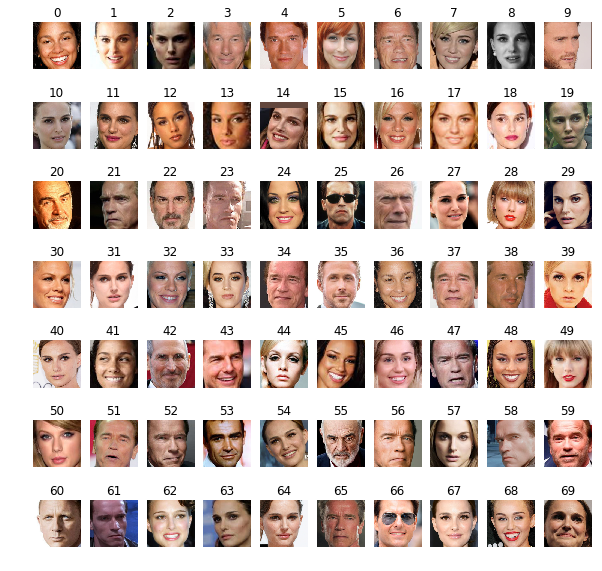

In [5]:
# Plot the image library for a reference. 
# This works fine for small amount of images (some tens), might be bad idea for larger libraries. 

n_img = images.shape[0]
cols = 10
rows = int(n_img / cols)
if rows * cols < n_img:
    rows += 1
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for index in range(n_img):    
    row = int(index / cols)
    col = index % cols
    axes[row, col].imshow(images[index]/2 + .5)
    axes[row, col].axis('off')
    axes[row, col].set_title(str(index))

plt.show()

## Neural network model

In [6]:
class CNN_Model(object):
    # Class for the neural network model and related methods. 
    def __init__(self):
        # Load pretrained VGG16 model. 
        model = VGG16(weights='imagenet')

        # Pop the original output and configure the 4096 long flattened feature vector as new output.
        # If necessary, run model.summary() for details. 
        model.layers.pop()
        last = model.layers[-1].output
        self.model = Model(model.input, last)
        self.model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    def run_inference(self, img):
        vect = self.model.predict(np.expand_dims(img, axis=0), verbose=0) 
        return vect

In [ ]:
#  Get the CNN model instance.
model = CNN_Model()

# Get feature vector for each image. 
# This uses batch size of 1 to make sure that the code runs well with practically any PC.
# Larger batch size will consume more memory for the intermediate results, but may speed up the processing
# especially on GPU. 

n_img = images.shape[0]
vectors = np.full((n_img, VECTOR_SIZE), 0.)

print('Vectorizing {} images'.format(n_img))
for index in range(n_img):    
    vectors[index] = model.run_inference(images[index])
    if index%10 == 0:
        print(index)

## Embedding vector processing

In [8]:
def distance(vect1, vect2, method='cosine'): 
    if method == 'cosine':
        return spatial.distance.cosine(vect1, vect2)
    
    elif method == 'euclidean':
        return spatial.distance.euclidean(vect1, vect2)

    
class PCA_Model(object):
    def __init__(self, X, n_components=50, whiten=False):
        self.pca = PCA(n_components, whiten, svd_solver='full')
        self.pca.fit(X)
        
    def transform(self, data):
        return self.pca.transform(data)
        
    def get_expl_var_ratio(self):
        return self.pca.explained_variance_ratio_

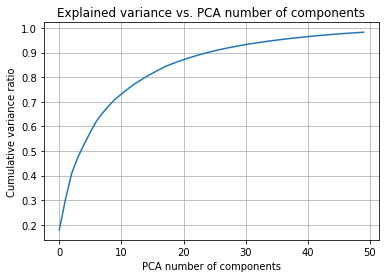

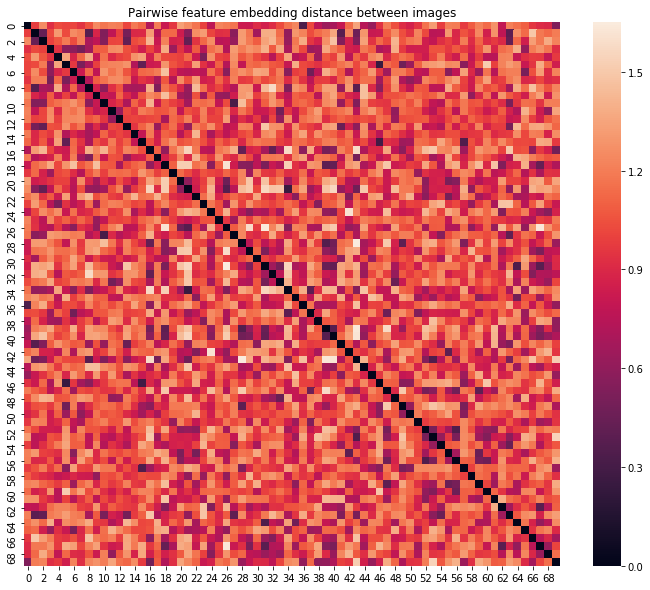

In [9]:
# Get the PCA instance and fit it. Note that the sklearn PCA seems to modify the
# X array during fitting process, so one should always give copy instead of reference.
pca = PCA_Model(X=vectors.copy())
pca_vectors = pca.transform(vectors)

plt.plot(np.cumsum(pca.get_expl_var_ratio()))
plt.title('Explained variance vs. PCA number of components')
plt.xlabel('PCA number of components')
plt.ylabel('Cumulative variance ratio')
plt.grid()
plt.show()

# Plot pairwise embedding distances. Just for fun...
n_img = images.shape[0]
distances = np.full((n_img, n_img), 0.)
for y in range(n_img): 
    for x in range(n_img):
        distances[y, x] = distance(pca_vectors[x], pca_vectors[y], method='cosine')

plt.figure(figsize=(12,10))
plt.title('Pairwise feature embedding distance between images')
sns.heatmap(distances)
plt.show()



## Image search

In [10]:
def find_matching_image(ref_img_path):
    # Load ref image.
    face = load_ref_image(ref_img_path)
    if face is None:
        return None
    # Get the ref image feature vector.
    face_vector = model.run_inference(face)
    face_vector_pca = pca.transform(face_vector)
    
    # Search the matching vector
    n_vectors = pca_vectors.shape[0]
    
    result_vector = np.full((n_vectors), 0.)
    for i in range(n_vectors):
        result_vector[i] = distance(face_vector_pca, pca_vectors[i])
    
    result_index = np.nanargmin(result_vector)
    result_filename = filenames[result_index]
    return result_filename   
    
def plot_img_pair(ref_img_path, best_match_path):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(load_image(ref_img_path))
    axes[0].set_title('Search reference')
    axes[0].axis('off')
    axes[1].imshow(load_image(best_match_path))
    axes[1].set_title('Best match')
    axes[1].axis('off')
    plt.show()

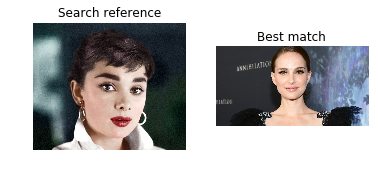

In [11]:
# Example 1
reference_img_path = 'Test/Audrey_1.jpg'
best_match_filename = find_matching_image(reference_img_path)
plot_img_pair(reference_img_path, best_match_filename)

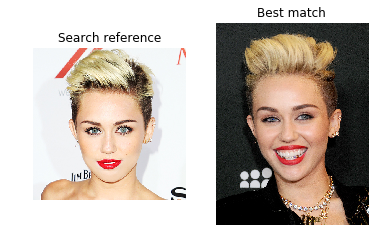

In [12]:
# Example 2
reference_img_path = 'Test/Miley.jpg'
best_match_filename = find_matching_image(reference_img_path)
plot_img_pair(reference_img_path, best_match_filename)

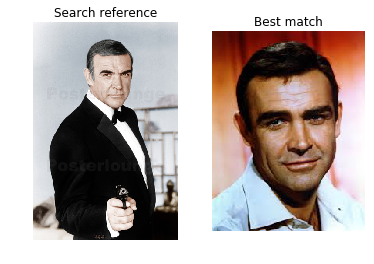

In [13]:
# Example 3
reference_img_path = 'Test/Sean.jpg'
best_match_filename = find_matching_image(reference_img_path)
plot_img_pair(reference_img_path, best_match_filename)